# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [1]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [2]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(226800, 40)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [3]:
# scaler를 이용한 정규화

import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

print(X_train.shape)
print(y_train.shape)
X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
print(X_train_3d.shape)
y_train_3d = y_train[::maxlen]
print(y_train_3d.shape)

X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
print(X_valid_3d.shape)
y_valid_3d = y_valid[::maxlen]
print(y_valid_3d.shape)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

(226800, 40)
(226800,)
(3240, 70, 40)
(3240,)
(360, 70, 40)
(360,)
(400, 70, 40)
(400,)


# Model 설계 

## lstm

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

feature_dim = X_train.shape[-1]

simple_model = Sequential()
simple_model.add(Dense(128, activation='relu', input_shape=(maxlen, feature_dim)))
simple_model.add(Dropout(0.2))
simple_model.add(Flatten())
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dropout(0.2))
simple_model.add(Dense(18, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

In [13]:
simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 70, 128)           5248      
                                                                 
 dropout_2 (Dropout)         (None, 70, 128)           0         
                                                                 
 flatten_1 (Flatten)         (None, 8960)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                573504    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 18)                1170      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [14]:
simple_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'AUC'])

In [15]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
batch_size = 40
model_name = 'chp_simple_model.h5'

early_stopping = EarlyStopping(monitor='val_auc', patience=4, verbose=1)
checkpoint = ModelCheckpoint(path+model_name, monitor='val_auc', save_best_only=True)

cnn_history = simple_model.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d), callbacks=[early_stopping, checkpoint])


Epoch 1/20
81/81 [==============================] - 1s 9ms/step - loss: 0.3793 - acc: 0.8620 - auc: 0.6652 - val_loss: 0.3345 - val_acc: 0.8639 - val_auc: 0.8022
Epoch 2/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3383 - acc: 0.8685 - auc: 0.7589 - val_loss: 0.3214 - val_acc: 0.8639 - val_auc: 0.8149
Epoch 3/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3278 - acc: 0.8688 - auc: 0.7830 - val_loss: 0.3172 - val_acc: 0.8667 - val_auc: 0.8222
Epoch 4/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3234 - acc: 0.8722 - auc: 0.7912 - val_loss: 0.3199 - val_acc: 0.8556 - val_auc: 0.8228
Epoch 5/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3212 - acc: 0.8747 - auc: 0.7928 - val_loss: 0.3206 - val_acc: 0.8528 - val_auc: 0.8190
Epoch 6/20
81/81 [==============================] - 0s 5ms/step - loss: 0.3176 - acc: 0.8762 - auc: 0.8008 - val_loss: 0.3222 - val_acc: 0.8556 - val_auc: 0.8286
Epoch 7/20
81/81 [==========

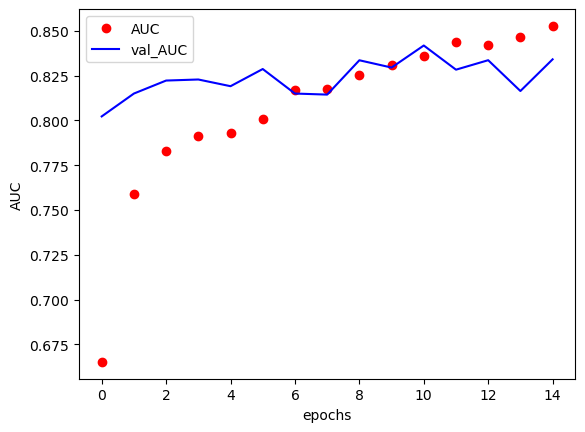

In [16]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = simple_model.history.history
history
loss = history['loss']
acc = history['acc']
auc = history['auc']
val_loss = history['val_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
length = len(val_loss)

plt.plot(range(length), auc, 'ro', label='AUC')
plt.plot(range(length), val_auc, 'b-', label='val_AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend()

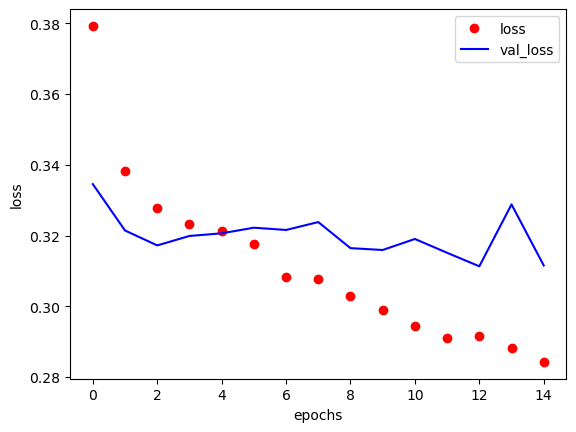

In [17]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [18]:
# test loss, acc, auc 구하기1
test_loss, test_acc, test_auc = simple_model.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.4f}')
print(f'test_auc: {test_auc:.4f}')


# auroc 구하기2
from sklearn.metrics import roc_auc_score

test_pred = simple_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 2ms/step - loss: 0.3054 - acc: 0.8700 - auc: 0.8279
test_acc: 0.8700
test_auc: 0.8279
13/13 [==============================] - 0s 2ms/step
acc_test: 0.8700
auc_score_test: 0.8279


In [20]:
simple_model.save(path+'simple_model_best_upto.h5')

In [23]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score

# model_name
# 'simple_model_best_upto.h5'
loaded_model = load_model(path+model_name)

test_loss, test_acc, test_auc = loaded_model.evaluate(X_test_3d, y_test_3d)
test_pred = loaded_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 2ms/step
acc_test: 0.8700
auc_score_test: 0.7948


### 어떻게 checkpoint 건 결과가 더 안좋게 나오지??